In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

In [84]:
def plot_true_vs_predicted(ax, y_true, y_pred, title):
    """
    Plot true vs predicted values on the given Axes object.

    Parameters:
    - ax: Matplotlib Axes object to plot on.
    - y_true: True target values.
    - y_pred: Predicted values from the model.
    - title: Title for the plot.
    """
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_title(title)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    
def create_metrics_table_plotly(train_rmse, train_mae, train_r2, val_rmse, val_mae, val_r2, test_rmse, test_mae, test_r2, vrh_rmse, vrh_mae, vrh_r2):
    """
    Create an interactive table of error metrics using Plotly.

    Parameters:
    - train_rmse, train_mae, train_r2: Training RMSE, MAE, and R-squared metrics
    - val_rmse, val_mae, val_r2: Validation RMSE, MAE, and R-squared metrics
    - test_rmse, test_mae, test_r2: Test RMSE, MAE, and R-squared metrics
    - vrh_rmse, vrh_mae, vrh_r2: RMSE, MAE, and R-squared metrics on VRH values

    Returns:
    - A Plotly figure containing the metrics table.
    """
    # Header
    header_values = ["Metrics", "Training", "Validation", "Test", "VRH"]
    # Cells
    cell_values = [
        ["RMSE", "MAE", "R-squared"],
        [f"{train_rmse:.2f}", f"{train_mae:.2f}", f"{train_r2:.4f}"],
        [f"{val_rmse:.2f}", f"{val_mae:.2f}", f"{val_r2:.4f}"],
        [f"{test_rmse:.2f}", f"{test_mae:.2f}", f"{test_r2:.4f}"],
        [f"{vrh_rmse:.2f}", f"{vrh_mae:.2f}", f"{vrh_r2:.4f}"]
    ]
    
    # Initialize a figure with go.Table
    fig = go.Figure(data=[go.Table(
        header=dict(values=header_values,
                    fill_color='paleturquoise',
                    align='center',
                    font=dict(color='black', size=12)),
        cells=dict(values=cell_values,
                   fill_color='lavender',
                   align='center'))
    ])
    return fig


def plot_results(xlabel, df, predictions, sonic, v_label, r_label, vrh_label, xlim_lr, xlim_upr, ylim_lr = False, ylim_upr = False, bckg = False):
    """
    Plots various geological log data and machine learning predictions as a function of depth.
    
    Parameters:
    - xlabel (str): Label for the x-axis.
    - df (DataFrame): Pandas DataFrame containing the well log data.
    - predictions (array-like): Predicted values from a machine learning model.
    - sonic (array-like): Sonic log values from the DataFrame.
    - v_label (str): Column name in df for Voigt boundary data.
    - r_label (str): Column name in df for Reuss boundary data.
    - vrh_label (str): Column name in df for Voigt-Reuss-Hill average data.
    - xlim_lr (float): Lower limit for the x-axis range.
    - xlim_upr (float): Upper limit for the x-axis range.
    - ylim_lr (float, optional): Lower limit for the y-axis range. Defaults to False, which auto-scales.
    - ylim_upr (float, optional): Upper limit for the y-axis range. Defaults to False, which auto-scales.
    - bckg (str or False, optional): Background color for the area between Voigt and Reuss boundaries. If False, yellow is used as the default color.
    
    The function creates a vertical plot typically used for well log representation with depth increasing downwards. 
    It plots the sonic log, machine learning predictions, and the Voigt-Reuss-Hill average as lines on the same plot. 
    It also shades the area between the Voigt and Reuss boundaries to indicate uncertainty or variability range. 
    The function allows for customization of the x and y-axis limits and the background color for the shaded area.
    """

    depth = df['DEPT']
    voigt_boundary = df[v_label]
    reuss_boundary = df[r_label]
    vp_vrh = df[vrh_label]
    xlen = df.shape[0]
    
    plt.figure(figsize=(9, 10))
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    
    for _, el in formation_depths.iterrows():
        plt.axhline(y=el['Min Value'], color='grey', linestyle='--', linewidth=1, alpha=0.3)
        plt.axhline(y=el['Max Value'], color='grey', linestyle='--', linewidth=1, alpha=0.3)
                
    plt.plot(sonic, depth, label='Sonic Log', alpha=1)
    plt.plot(predictions, depth, label='ML Predictions', alpha=0.8, color='red')
    plt.plot(vp_vrh, depth, label='Voigt Reuss Hill', alpha=0.5, color='black')
    plt.plot(voigt_boundary, depth,  alpha=0.8, linewidth=0.4, color='violet')
    plt.plot(reuss_boundary, depth, label='Voigt-Reuss Boundaries', alpha=0.8, linewidth=0.4, color='violet')
    
    if bckg:
        plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                      interpolate=True, color=bckg, alpha=0.5)
    else:
        plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                      interpolate=True, color='yellow', alpha=0.5)
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2, 
               framealpha=1.0, edgecolor='black', facecolor='white', frameon=True)
    
    plt.ylabel('Depth [m]', fontweight='bold', labelpad=15)
    plt.xlabel(xlabel, fontweight='bold', labelpad=15)
    
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'arial'
    
    plt.xlim(xlim_lr, xlim_upr)
    if (ylim_lr and ylim_upr):
        plt.ylim(ylim_lr, ylim_upr)

    plt.show()
    
def plot_true_vs_predicted_v1(ax, true_data, predicted_data, label, marker, color):
    ax.scatter(true_data, predicted_data, alpha=0.7, label=label, marker=marker, color=color)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.legend()
    
def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))
    
def plot_true_vs_vrh(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.4, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('VRH Values', fontweight='bold')
    ax.set_title('True vs VRH', fontweight='bold')
    plt.xlim(2000, 7000)
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))
    
def calculate_voigt_reuss_bounds(df, minerals, bulk_modulus, shear_modulus):
    dataset = df[minerals]
    voigt_bulk = []
    reuss_bulk = []
    voigt_shear = []
    reuss_shear = []
    
    for index, row in dataset.iterrows():
        sum_voigt_bulk = sum_voigt_shear = 0
        sum_reuss_bulk = sum_reuss_shear = 0
        for mineral in minerals:
            volume_fraction = row[mineral]
            sum_voigt_bulk += volume_fraction * bulk_modulus[mineral]
            sum_voigt_shear += volume_fraction * shear_modulus[mineral]
            # Avoiding /0
            if bulk_modulus[mineral] > 0:
                sum_reuss_bulk += volume_fraction / bulk_modulus[mineral]
            if shear_modulus[mineral] > 0:
                sum_reuss_shear += volume_fraction / shear_modulus[mineral]
        voigt_bulk.append(sum_voigt_bulk)
        voigt_shear.append(sum_voigt_shear)
        reuss_bulk_value = 1 / sum_reuss_bulk if sum_reuss_bulk > 0 else 0
        reuss_shear_value = 1 / sum_reuss_shear if sum_reuss_shear > 0 else 0
        reuss_bulk.append(reuss_bulk_value)
        reuss_shear.append(reuss_shear_value)
        
        df.loc[index, 'Voigt_Bulk'] = sum_voigt_bulk
        df.loc[index, 'Reuss_Bulk'] = reuss_bulk_value
        df.loc[index, 'Voigt_Shear'] = sum_voigt_shear
        df.loc[index, 'Reuss_Shear'] = reuss_shear_value
    df['K_VRH'] = (df['Voigt_Bulk']+df['Reuss_Bulk'])/2
    df['G_VRH'] = (df['Voigt_Shear']+df['Reuss_Shear'])/2
    
    return df

In [85]:
# Importing the Data
df = pd.read_csv("./../DATASETS/Training and Testing data/df.csv")

train_df_vp = pd.read_csv("./../DATASETS/Training and Testing data/train_df_vp.csv")
test_df_vp = pd.read_csv("./../DATASETS/Training and Testing data/test_df_vp.csv")
test_df2_vp = pd.read_csv("./../DATASETS/Training and Testing data/test_df2_vp.csv")

train_df_vs = pd.read_csv("./../DATASETS/Training and Testing data/train_df_vs.csv")
test_df_vs = pd.read_csv("./../DATASETS/Training and Testing data/test_df_vs.csv")
test_df2_vs = pd.read_csv("./../DATASETS/Training and Testing data/test_df2_vs.csv")

formations = pd.read_excel("./../Datasets/Input data/Rock Formation Depths.xlsx")

In [86]:
# Generating a Dataframe with required rock formation Depths

layers = {
    "Layer": [
        "Eau Claire A-C", "Mt. Simon E", "Mt. Simon D", "Mt. Simon C",
        "Mt. Simon B", "Mt. Simon A", "Argenta", "Precambrian rhyolite"
    ],
    "Min Value": [5380, 5552, 5907, 6117, 6428, 6668, 7043, 7162],
    "Max Value": [5552, 5907, 6117, 6428, 6668, 7043, 7162, 8000],
    "color": ['grey','purple','purple','purple','purple','purple','red','blue']
}
formation_depths = pd.DataFrame(layers)

In [87]:
def feet_to_meters(feet):
    return feet * 0.3048

test_df_vs['DEPT'] = test_df_vs['DEPT'].apply(feet_to_meters)
test_df_vp['DEPT'] = test_df_vp['DEPT'].apply(feet_to_meters)

test_df2_vs['DEPT'] = test_df2_vs['DEPT'].apply(feet_to_meters)
test_df2_vp['DEPT'] = test_df2_vp['DEPT'].apply(feet_to_meters)

In [88]:
formation_depths['Min Value'] = formation_depths['Min Value'].apply(feet_to_meters)
formation_depths['Max Value'] = formation_depths['Max Value'].apply(feet_to_meters)

## P Wave Velocity Prediction

In [89]:
target_column = 'VP'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vp[predictor_cols]
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [90]:
filename = './../Model Weights/Random Forest for P-Wave Velocity/random_forest_vp.joblib'
best_rf = joblib.load(filename)

In [91]:
# Evaluate the best model on the validation set
val_predictions = best_rf.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

print('Validation MAE: ', val_mae)
print('Validation R-squared: ', val_r2)

Validation MAE:  155.82420061063885
Validation R-squared:  0.945055610646722


In [92]:
X_test = test_df_vp.drop(['VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vp['VP']
X_test_scaled = scaler.transform(X_test)

y_test_pred_vp = best_rf.predict(X_test_scaled)
y_val_pred = best_rf.predict(X_val_scaled)
y_train_pred = best_rf.predict(X_train_scaled)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

test_rmse = mean_squared_error(y_test, y_test_pred_vp, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_vp)
test_r2 = r2_score(y_test, y_test_pred_vp)

vrh_rmse = mean_squared_error(y_test, list(test_df_vp['VRH_VP']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vp['VRH_VP']))
vrh_r2 = r2_score(y_test, list(test_df_vp['VRH_VP']))

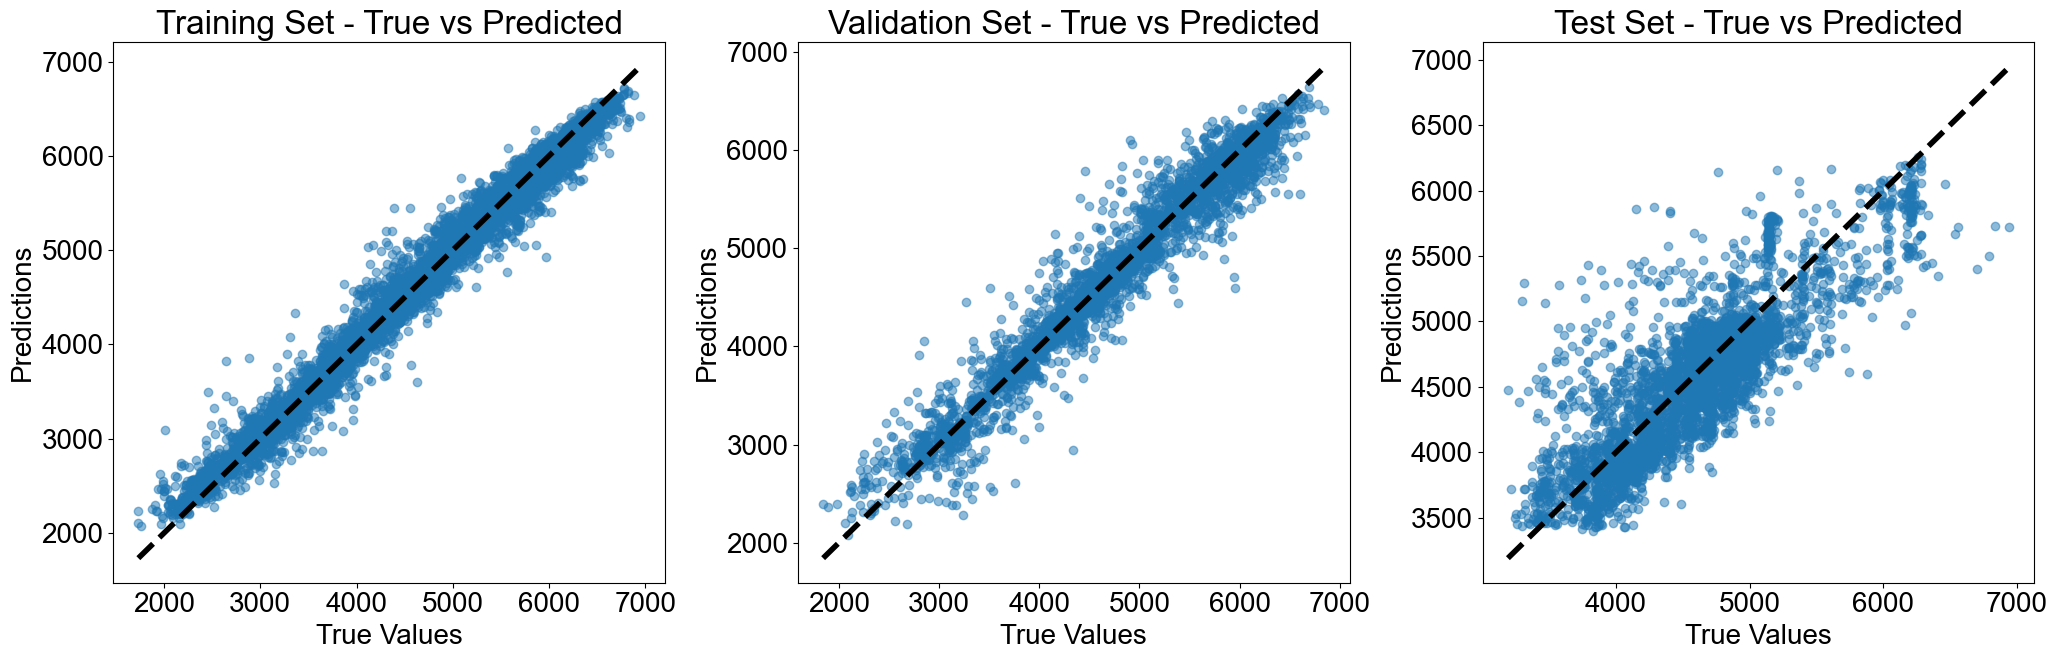

In [93]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, y_train_pred, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, y_val_pred, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, y_test_pred_vp, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

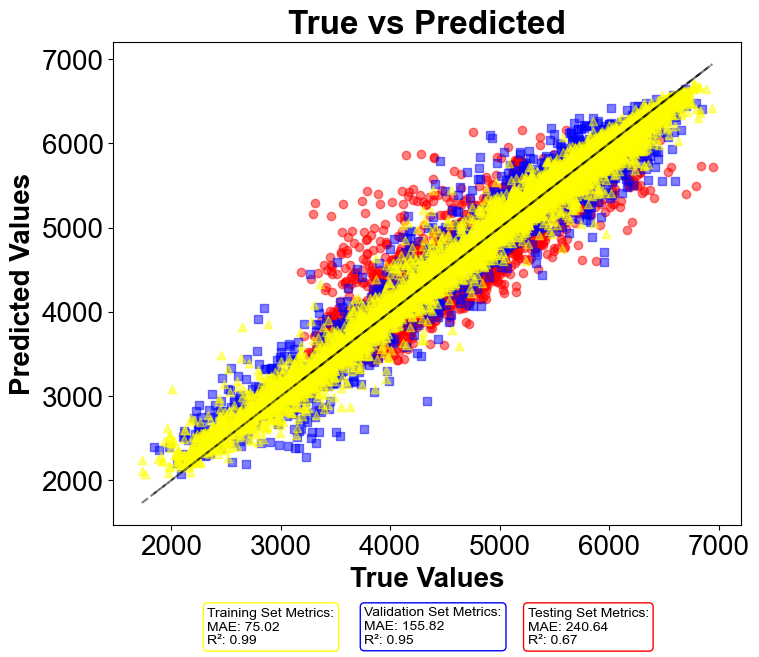

In [94]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v2(ax, y_test, y_test_pred_vp, 'Testing Set', 'o', 'red', 0.66, -0.17)
plot_true_vs_predicted_v2(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue', 0.4, -0.17)
plot_true_vs_predicted_v2(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow', 0.15, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [95]:
def calculate_vpvrh(df):
    # (1 GPa = 1e9 Pa)
    KVRH = df['K_VRH'] * 1e9
    GVRH = df['G_VRH'] * 1e9
    
    # (1 g/cm^3 = 1000 kg/m^3)
    rho = df['RHOZ'] * 1000
    
    df['VRH_VP'] = np.sqrt((KVRH + 4.0/3.0 * GVRH) / rho)
    return df

train_df_vp = calculate_vpvrh(train_df_vp)

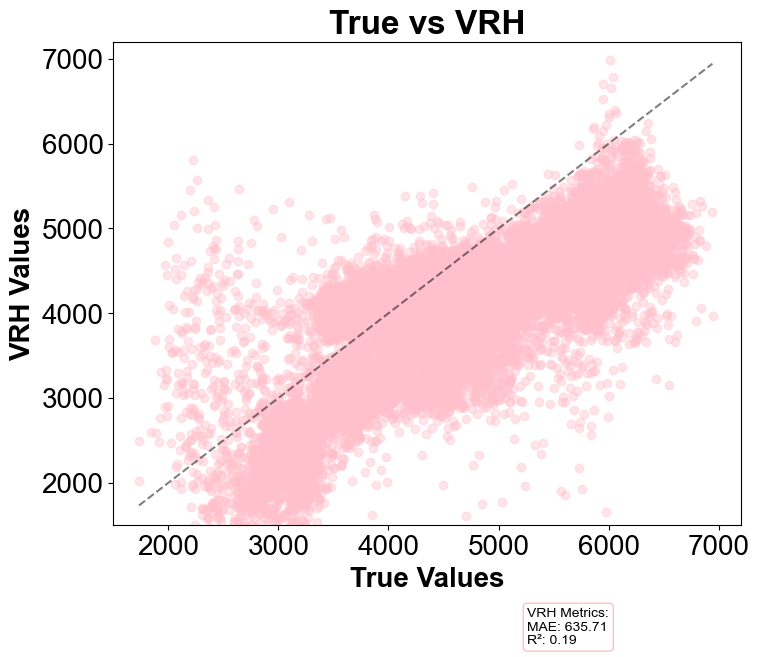

In [96]:
def plot_true_vs_vrh(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.4, label=f'{label}', color=color, marker=marker)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('VRH Values', fontweight='bold')
    ax.set_title('True vs VRH', fontweight='bold')
    plt.xlim(1500, 7200)
    plt.ylim(1500, 7200)
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

plot_true_vs_vrh(ax, df['VP'], df['VRH_VP'], 'VRH', 'o', 'pink', 0.66, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

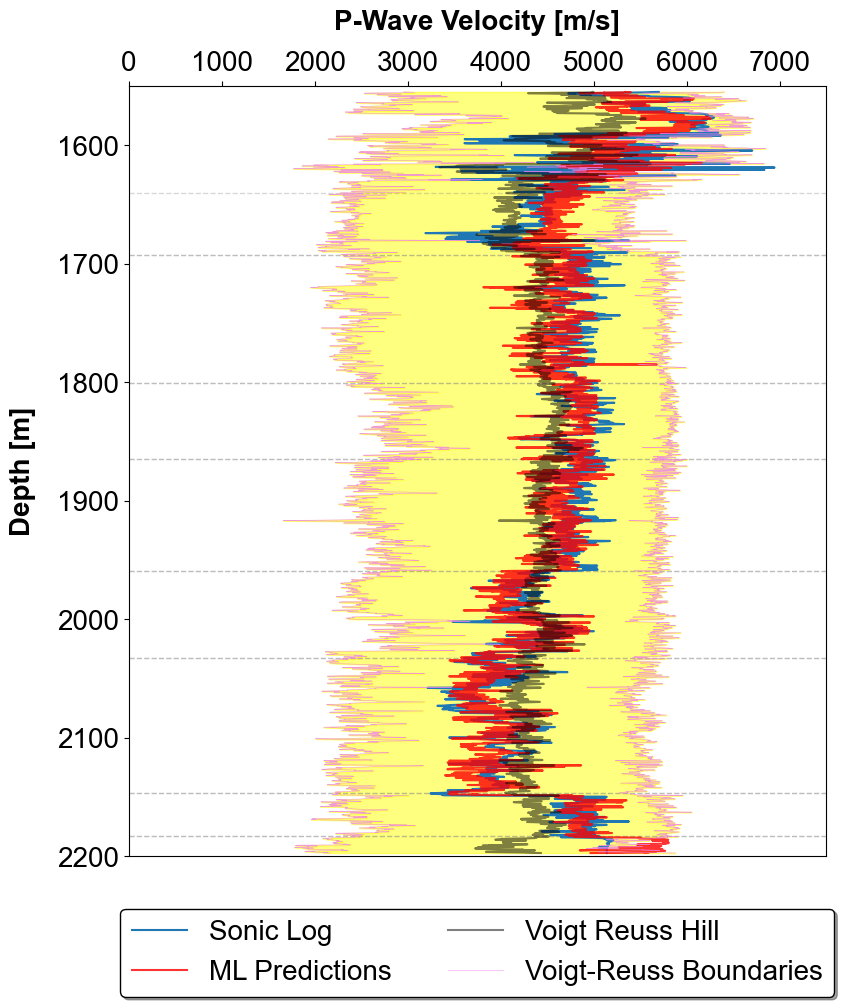

In [97]:
plot_results('P-Wave Velocity [m/s]', test_df_vp, y_test_pred_vp, y_test, 'VOIGT_VP', 'REUSS_VP','VRH_VP', 0, 7500, 2200, 1550)

## S Wave Velocity Prediction

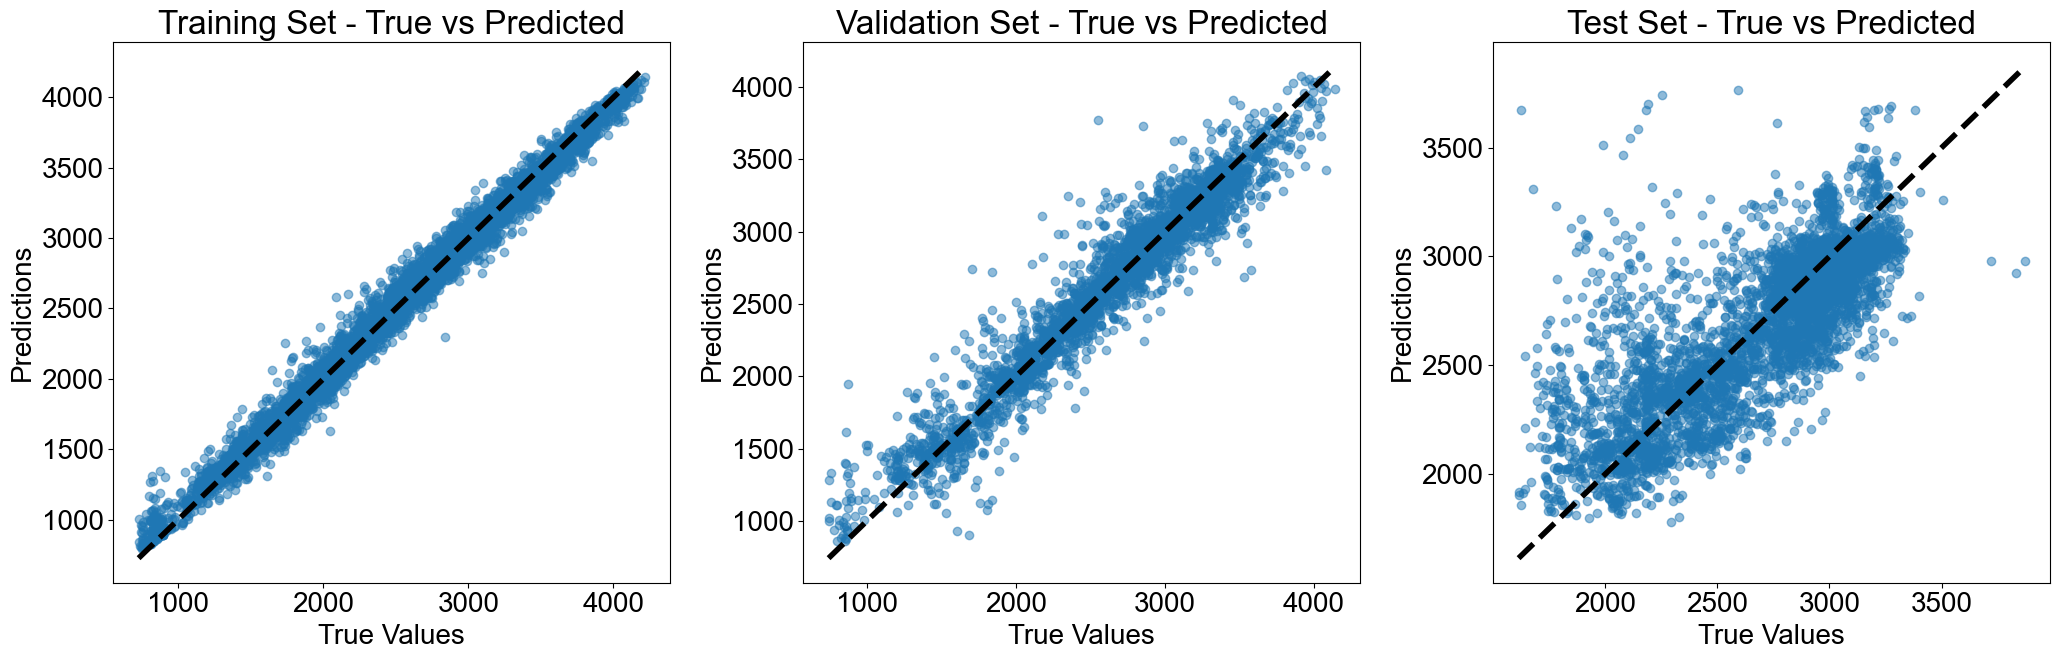

In [100]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target_column = 'VS'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',
                  'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vs[predictor_cols]
y = train_df_vs[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Load the Weights
filename = './../Model Weights/Random Forest for S-Wave Velocity/random_forest_vs.joblib'
model = joblib.load(filename)
y_test = test_df_vs['VS']

# Predictions
train_predictions = model.predict(X_train_scaled)
val_predictions = model.predict(X_val_scaled)
test_predictions = model.predict(X_test_scaled)

# Evaluation Metrics
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

vrh_rmse = mean_squared_error(y_test, test_df_vs['VRH_VS'], squared=False)
vrh_mae = mean_absolute_error(y_test, test_df_vs['VRH_VS'])
vrh_r2 = r2_score(y_test, test_df_vs['VRH_VS'])

# Plot true vs predicted
plt.figure(figsize=(21, 7))

ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, train_predictions, 'Training Set - True vs Predicted')

ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, val_predictions, 'Validation Set - True vs Predicted')

ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, test_predictions, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

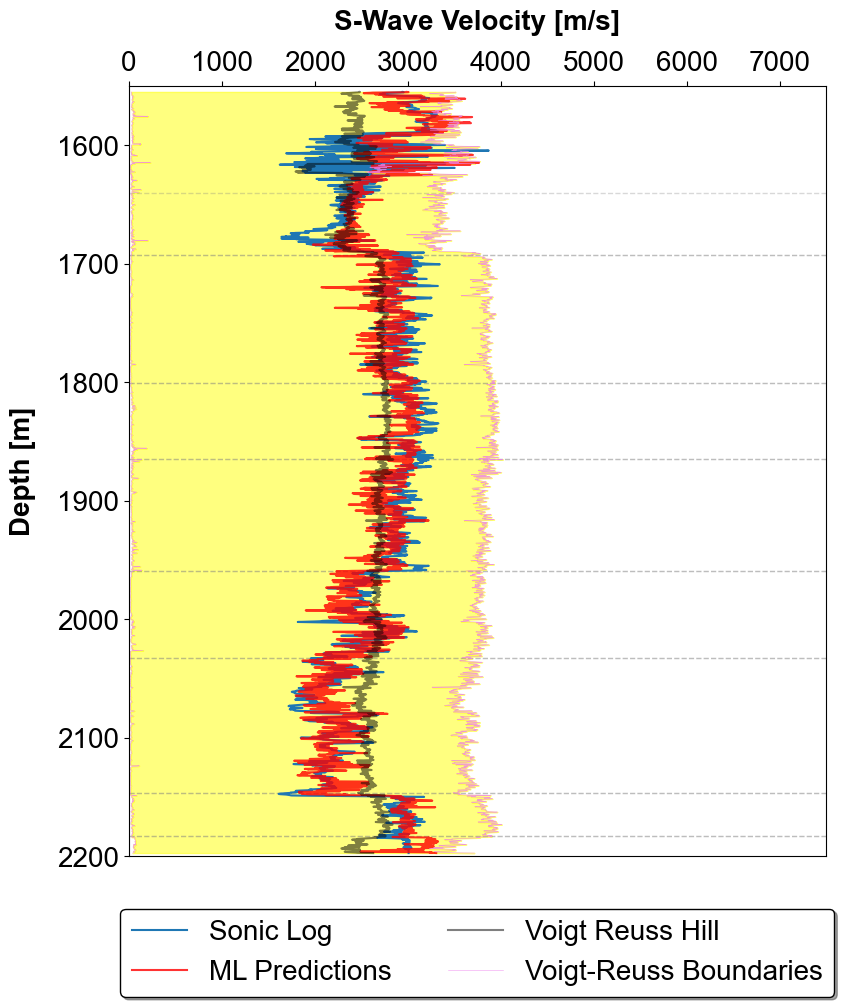

In [101]:
plot_results(
    'S-Wave Velocity [m/s]',
    test_df_vs,
    test_predictions,
    y_test,
    'VOIGT_VS',
    'REUSS_VS',
    'VRH_VS',
    0,
    7500,
    2200,
    1550
)